In [1]:
!pip install pytorch-lightning --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 851.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 54.3 MB/s eta 0:00:00


In [2]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

# set random seeds
pl.seed_everything(42)
torch.manual_seed(42)
np.random.seed(42)

INFO:lightning_fabric.utilities.seed:Seed set to 42


In [3]:
class NonLinearDataset(Dataset):
    def __init__(self, n_samples=1000):
        X1 = np.random.uniform(-5, 5, n_samples)
        X2 = np.random.uniform(-5, 5, n_samples)
        X3 = np.random.uniform(-5, 5, n_samples)

        y = (2 * np.sin(X1) + 0.5 * X2**2 + 0.3 * X3**3 +
             np.cos(X1 * X2) + np.random.normal(0, 0.2, n_samples))

        self.X = torch.FloatTensor(np.column_stack((X1, X2, X3)))
        self.y = torch.FloatTensor(y.reshape(-1, 1))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [4]:
class NonLinearRegressorPL(pl.LightningModule):
    def __init__(self, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters()

        self.network = nn.Sequential(
            nn.Linear(3, 64), nn.ReLU(), nn.BatchNorm1d(64), nn.Dropout(0.2),
            nn.Linear(64, 32), nn.ReLU(), nn.BatchNorm1d(32), nn.Dropout(0.2),
            nn.Linear(32, 16), nn.ReLU(), nn.BatchNorm1d(16), nn.Dropout(0.2),
            nn.Linear(16, 1)
        )

        self.criterion = nn.MSELoss()
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, x):
        return self.network(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss"
            }
        }

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.training_step_outputs.append({'loss': loss})
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.validation_step_outputs.append({'loss': loss})
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('test_loss', loss)
        self.test_step_outputs.append({'x': x, 'y': y, 'y_hat': y_hat})
        return loss

    def on_train_epoch_end(self):
        avg_loss = torch.stack([x['loss'] for x in self.training_step_outputs]).mean()
        self.log('train_epoch_loss', avg_loss)
        self.training_step_outputs.clear()

    def on_validation_epoch_end(self):
        avg_loss = torch.stack([x['loss'] for x in self.validation_step_outputs]).mean()
        self.log('val_epoch_loss', avg_loss)
        self.validation_step_outputs.clear()

    def on_test_epoch_end(self):
        self.test_results = {
            'x': torch.cat([x['x'] for x in self.test_step_outputs]),
            'y': torch.cat([x['y'] for x in self.test_step_outputs]),
            'y_hat': torch.cat([x['y_hat'] for x in self.test_step_outputs])
        }
        self.test_step_outputs.clear()

In [5]:
class DataModule(pl.LightningDataModule):
    def __init__(self, batch_size=32):
        super().__init__()
        self.batch_size = batch_size

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train_dataset = NonLinearDataset(1000)
            self.val_dataset = NonLinearDataset(200)
        if stage == 'test' or stage is None:
            self.test_dataset = NonLinearDataset(200)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

In [6]:
def plot_results(trainer, model, datamodule):
    trainer.test(model, datamodule)
    test_results = model.test_results

    fig = plt.figure(figsize=(20, 5))

    # 4D scatter plot
    ax2 = fig.add_subplot(132, projection='3d')
    scatter = ax2.scatter(test_results['x'][:, 0].cpu(),
                          test_results['x'][:, 1].cpu(),
                          test_results['x'][:, 2].cpu(),
                          c=test_results['y_hat'].cpu().numpy(),
                          cmap='viridis')
    plt.colorbar(scatter, label='Predicted Value')
    ax2.set_xlabel('X1')
    ax2.set_ylabel('X2')
    ax2.set_zlabel('X3')
    ax2.set_title('4D Scatter Plot\n(Color = Prediction)')

    # actual vs predicted values
    ax3 = fig.add_subplot(133)
    ax3.scatter(test_results['y'].cpu(), test_results['y_hat'].cpu(), alpha=0.5)
    min_val = min(test_results['y'].min(), test_results['y_hat'].min())
    max_val = max(test_results['y'].max(), test_results['y_hat'].max())
    ax3.plot([min_val, max_val], [min_val, max_val], 'r--')
    ax3.set_xlabel('Actual Values')
    ax3.set_ylabel('Predicted Values')
    ax3.set_title('Actual vs Predicted Values')

    plt.tight_layout()
    plt.show()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training the model...


INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | network   | Sequential | 3.1 K  | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Plotting results...


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    3.8669891357421875     │
└───────────────────────────┴───────────────────────────┘

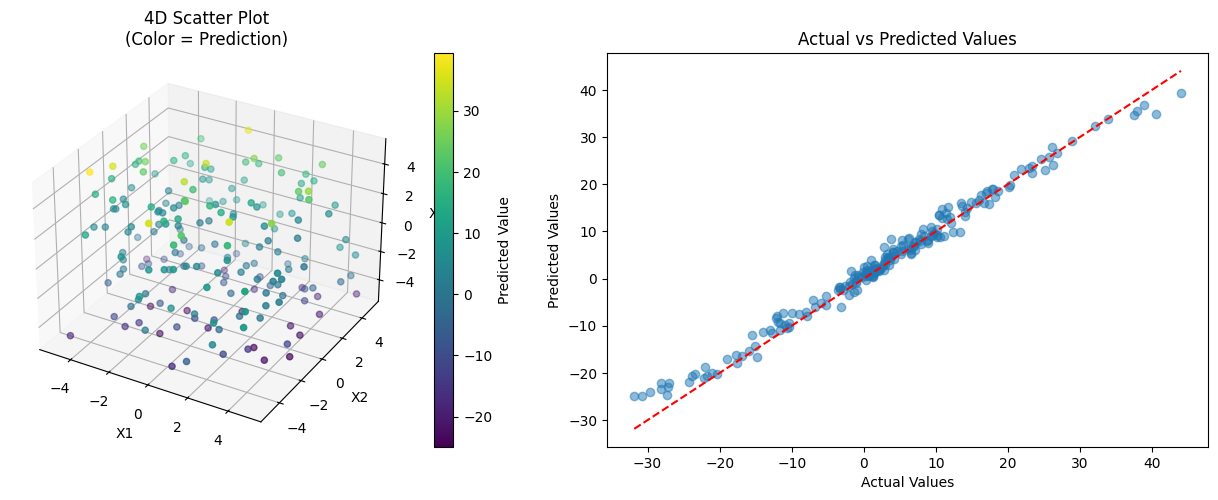


Test Predictions:
Input: (-4, -4, -4)
Prediction: -9.934
Actual: -10.644
Difference: 0.710

Input: (-2, -2, -2)
Prediction: -0.800
Actual: -2.872
Difference: 2.072

Input: ( 0,  0,  0)
Prediction: 0.780
Actual: 1.000
Difference: 0.220

Input: ( 2,  2,  2)
Prediction: 6.491
Actual: 5.565
Difference: 0.926

Input: ( 4,  4,  4)
Prediction: 25.507
Actual: 24.729
Difference: 0.778



In [7]:
def main():
    datamodule = DataModule(batch_size=32)
    model = NonLinearRegressorPL(learning_rate=0.001)

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min')
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        dirpath='./checkpoints',
        filename='nonlinear-regressor-{epoch:02d}-{val_loss:.4f}',
        save_top_k=1,
        mode='min'
    )
    logger = TensorBoardLogger("lightning_logs", name="nonlinear_regressor")

    trainer = pl.Trainer(
        max_epochs=100,
        callbacks=[early_stopping, checkpoint_callback],
        logger=logger,
        accelerator='auto',
        devices=1,
        enable_progress_bar=True
    )

    print("Training the model...")
    trainer.fit(model, datamodule)

    print("\nPlotting results...")
    plot_results(trainer, model, datamodule)

    # predictions
    print("\nTest Predictions:")
    @torch.no_grad()
    def test_model(x1, x2, x3):
        model.eval()
        x = torch.FloatTensor([[x1, x2, x3]])
        return model(x).item()

    test_points = [(-4, -4, -4), (-2, -2, -2), (0, 0, 0), (2, 2, 2), (4, 4, 4)]

    for x1, x2, x3 in test_points:
        pred = test_model(x1, x2, x3)
        actual = 2 * np.sin(x1) + 0.5 * x2**2 + 0.3 * x3**3 + np.cos(x1 * x2)
        print(f"Input: ({x1:2d}, {x2:2d}, {x3:2d})")
        print(f"Prediction: {pred:.3f}")
        print(f"Actual: {actual:.3f}")
        print(f"Difference: {abs(pred - actual):.3f}\n")

main()